<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_4_cnn_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 11 - Redes Neurais Convolucionais

## 11.4 - Redes Neurais Convolucionais em Textos

In [ ]:
!pip install keras
!pip install tensorflow

In [3]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

### Carregamento do corpus para Pandas DataFrames

PS.: Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse link.

In [4]:
path_train = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013train-A.txt'
path_test = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013test-A.txt'
path_valid = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013dev-A.txt'

df_train = pd.read_csv(path_train,names=['id','polarity','text'],sep='\t')
df_valid = pd.read_csv(path_valid,names=['id','polarity','text'],sep='\t')
df_test = pd.read_csv(path_test,names=['id','polarity','text'],sep='\t')

In [5]:
print(f'Train size {df_train.shape}')
print(f'Valid size {df_valid.shape}')
print(f'Test size {df_test.shape}')

Train size (9684, 3)
Valid size (1654, 3)
Test size (3547, 3)


In [6]:
df_train = df_train.drop(labels=['id'],axis=1)
df_valid = df_valid.drop(labels=['id'],axis=1)
df_test = df_test.drop(labels=['id'],axis=1)

Geração dos Logits dos labels utilizando a função to_categorical do Tensorflow:

In [7]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
y_train_int = df_train['polarity'].cat.codes

df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
y_valid_int = df_valid['polarity'].cat.codes

df_test['polarity'] = pd.Categorical(df_test['polarity'])
y_test_int = df_test['polarity'].cat.codes

In [8]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

### Numericalização

Esse é o processo de transformar as palavras de um texto em números. Por exemplo: os textos

1.   "Eu quero jogar futebol"
2.   "Não dá para assistir futebol"
3.   "Não vou jogar meu boné fora"

Constrói-se o vocabulário com índices:

1. eu
2. quero
3. jogar
4. futebol
5. não
6. dá
7. para
8. assistir
9. vou
10. jogar
11. meu
12. boné
13. fora

Assim, a geração do vocabulário do *corpus* de treinamento **deve ser feita apenas para os textos de treinamento**, já que eles são conhecidos para os modelos de linguagem e de classificação:

In [9]:
train_tweets = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [10]:
vocab_size = len(vocabulary)

Outra possibilidade consiste em utilizar a classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) do tensorflow.

In [11]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['text'])

Com o word_index é possível ver o vocabulário e os índices de cada palavra:

In [ ]:
word_index = tokenizer.word_index
word_index

O próximo passo consiste em transformar as palavras em números de acordo com os índices do vocabulário. É o último passo da numericalização, em que se obtém um vetor de números inteiros a partir de um tweet de entrada. Fazendo-se para os textos de treinamento, tem-se que:

In [13]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])

Veja o resultado para um dos tweets de treinamento:

In [26]:
print(f"Tweet: {df_train['text'][0]}")
print('Tweet numericalizado: ')
print(train_sequences[0])
print(f'Quantidade de palavras no tweet: {len(train_sequences[0])}')

Tweet: Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
Tweet numericalizado: 
[2711, 68, 22, 191, 383, 72, 2909, 4, 57, 31, 2, 1966, 1127, 6, 115]
Quantidade de palavras no tweet: 15


Acontece que os tweets podem variar na quantidade de palavras e as redes neurais não processam os tweets representados em estruturas de dimensões distintas. Veja um outro exemplo de tweet de treinamento:

In [27]:
print(f"Tweet: {df_train['text'][2]}")
print('Tweet numericalizado: ')
print(train_sequences[2])
print(f'Quantidade de palavras no tweet: {len(train_sequences[2])}')

Tweet: its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.
Tweet numericalizado: 
[141, 61, 23, 4, 57, 8, 5680, 475, 3, 4, 30, 574, 501, 2177, 55, 35, 103, 10, 269]
Quantidade de palavras no tweet: 19


### Pós-processamento da numericalização

Vamos tornar todos os vetores numéricos acrescentando-se zeros ao final, precisamos fixar um tamanho para os vetores numéricos resultantes da numericalização.

Uma estratégia consiste em calcular a quantidade de tweets que existe para cada quantidade possível de palavras:

In [61]:
max_words = 50

hist = {}

hist['qtde'] = [x for x in range(0,max_words)]

lista = [0]*(max_words)
for x in train_sequences:
    lista[len(x)]+=1

hist['num tweets'] = lista

In [63]:
import plotly.express as px
fig = px.bar(pd.DataFrame.from_dict(hist),x='qtde',y='num tweets')
fig.show()

Pode-se verificar que grande parte dos tweets possui entre 10 e 30 palavras. Por isso, vamos ajustar o tamanho dos vetores numericalizados como 32:

In [64]:
max_length = 32

Assim, tweets cujos vetores numericalizados possuírem menos do que 32 palavras serão completados com zeros. Tweets que possuírem mais do que 32 palavras serão truncados (terão algumas palavras removidas)

A função que faz essas operações de truncamento e de padding é [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences). Ajustamos a seguir o tipo de truncamento (se é no início ou no final) e o padding (inclusão de zeros ocorre no início ou no final).

In [ ]:
trunc_type = 'post'
padding_type = 'post'

Agora vai...

In [65]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Veja o resultado

In [74]:
print('Tweet:')
print(df_train['text'][0])
print('\nVetor numericalizado do tweet:')
print(train_sequences[0])
print('\nVetor numericalizado pós-processado com padding e truncamento:')
print(train_padded[0])

Tweet:
Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)

Vetor numericalizado do tweet:
[2711, 68, 22, 191, 383, 72, 2909, 4, 57, 31, 2, 1966, 1127, 6, 115]

Vetor numericalizado pós-processado com padding e truncamento:
[2711   68   22  191  383   72 2909    4   57   31    2 1966 1127    6
  115    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [75]:
print('Tweet:')
print(df_train['text'][2])
print('\nVetor numericalizado do tweet:')
print(train_sequences[2])
print('\nVetor numericalizado pós-processado com padding e truncamento:')
print(train_padded[2])

Tweet:
its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.

Vetor numericalizado do tweet:
[141, 61, 23, 4, 57, 8, 5680, 475, 3, 4, 30, 574, 501, 2177, 55, 35, 103, 10, 269]

Vetor numericalizado pós-processado com padding e truncamento:
[ 141   61   23    4   57    8 5680  475    3    4   30  574  501 2177
   55   35  103   10  269    0    0    0    0    0    0    0    0    0
    0    0    0    0]


Finalmente, temos que numericalizar os tweets de validação e de testes:

In [76]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Arquitetura da Rede Neural Convolucional Profunda (RNCP)

Começamos pela camada de entrada da RNCP. Poderíamos até colocar os vetores numericalizados ou one-hot encoding como entrada da rede (utilizando a camada de [Input](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)), mas trata-se de um espaço esparso que é difícil de identificar relacionamentos entre as palavras (Fonte: [Word Embeddings Tensorflow](https://www.tensorflow.org/text/guide/word_embeddings)).

Por isso, uma abordagem mais apropriada trata-se da criação de word embeddings de tamanho fixo. Nessa representação, cada palavra é representada por um vetor de tamanho $n$ em que palavras similares em relação a um contexto possuem valores (codificação) parecidas:



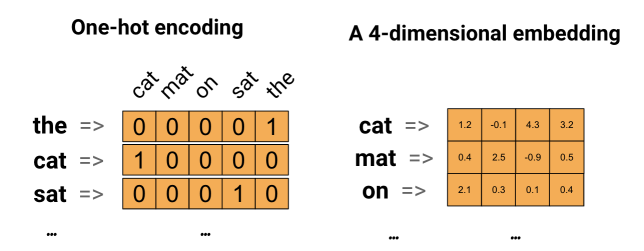

Podemos utilizar uma camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding), que possui pesos inicializados aleatoriamente e que são ajustados durante o treinamento via backpropagation.

No exemplo abaixo, vamos criar um embedding que gera vetores de 64 dimensões:

In [84]:
n = 16

embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=4,output_dim = n))

Veja como a predição ocorre para um vetor de entrada de quatro dimensões:

In [95]:
preds = embedding_model.predict([3,2,1,0])
print(preds[0])

[ 0.02419281  0.02042302  0.02822471 -0.03227498  0.00029599  0.04828881
  0.01439894 -0.00580289  0.03550393 -0.02386411  0.00295437 -0.03579586
 -0.01242872  0.00297586 -0.00435721  0.03569204]


Voltando para o problema de classificação de polaridade de tweets, vamos gerar embeddings de dimensão 32:

In [96]:
n = 32

Agora vamos implementar a arquitetura da nossa rede:



*   Camada [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D):
*   Camada [MaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) ou [AveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D): funciona da mesma maneira que as camadas Max Pooling 2D, reduzindo a dimensão dos vetores conforme o parâmetro de stride
*   Camada [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) ou [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D): funciona da mesma maneira que as camadas 



In [99]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = n, input_length=max_length))
model.add(Conv1D(128, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 32, 32)            768896    
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 128)           28800     
                                                                 
 conv1d_5 (Conv1D)           (None, 22, 128)           82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

In [ ]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=30)

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Avaliação com os Dados de Teste

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred))